In [2]:
import spikeinterface.extractors as se
import  spikeinterface.postprocessing as spost
import spikeinterface.core as sc
import spikeinterface as si
import spikeinterface.curation as curation
import numpy as np
from spikeinterface.extractors import BinaryRecordingExtractor
import spikeinterface.preprocessing as spre
import matplotlib.pyplot as plt
import json

In [11]:
def get_curated_id(curated_path):
    """
    unit id after auto curation
    curated_path: full path to "sorted.npz"
    """
    curated_py = np.load(curated_path, allow_pickle=True)
    curated_units = curated_py["units"]
    print("Number of units after auto curation: ", len(curated_units))
    unit_ids = [curated_units[i]["unit_id"] for i in range(len(curated_units))]
    channels = [curated_units[i]["electrode"] for i in range(len(curated_units))]   
    ch_unit_dict = {c:[] for c in channels}
    for k, v in zip(channels, unit_ids):
        ch_unit_dict[k].append(v)
    return ch_unit_dict


def set_channel_loc_np():
    channel_locs = []
    for row in range(384//2):
        y = 20 + 20 + 20 * row
        if row % 2 == 0:
            x = 27
        else:
            x = 11
        channel_locs.append((x+32, y))
        channel_locs.append((x, y))
    return channel_locs

In [4]:
# set path
rec = "rec0"
base_folder = "/media/kang/Seagate_External/TJ_data_25/" + rec
phy_path = base_folder + "/kilosort2_5_results"
auto_curation_path = base_folder + "/sorted.npz"
filtered_rec_path = phy_path + "/temp_wh.dat"

# set parameters
fs = 30000
channels = 384

In [5]:
curated_id = get_curated_id(auto_curation_path)
phy_result = se.KiloSortSortingExtractor(phy_path)
auto_curated = phy_result.select_units(curated_id)

curated_result = auto_curated

In [6]:
filtered_rec = BinaryRecordingExtractor(
        file_paths=filtered_rec_path,
        sampling_frequency=fs,
        num_chan=channels,
        dtype="int16",
        channel_ids=range(1, channels + 1)
    )
channel_locs = set_channel_loc_np()
filtered_rec.set_channel_locations(np.array(channel_locs))

we = sc.WaveformExtractor(filtered_rec, curated_result, base_folder, allow_unfiltered=True)
we.set_params(ms_before=2.0)
we.run_extract_waveforms()

extract waveforms memmap:   0%|          | 0/3656 [00:00<?, ?it/s]

In [9]:
print(we.recording)
print(we.sorting)

BinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 109,666,764 samples 
                          3,655.56s (1.02 hours) - int16 dtype - 78.44 GiB
  file_paths: ['/media/kang/Seagate_External/TJ_data_25/rec0/kilosort2_5_results/continuous_scaled_filtered.dat']
UnitsSelectionSorting: 570 units - 1 segments - 30.0kHz


In [12]:
ch_id_dict = get_curated_id(auto_curation_path)
with open("exclude_channels_TJ_np.json", 'r') as j:
     exclude_channels = json.loads(j.read())[rec]
print(exclude_channels)
selected_units = []
for k, v in ch_id_dict.items():
    if k not in exclude_channels:
        selected_units += v

auto_curated = curated_result.select_units(selected_units)
we.sorting = auto_curated
print(we.sorting)

Number of units after auto curation:  570
[49, 61, 96, 100, 115, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384]
UnitsSelectionSorting: 551 units - 1 segments - 30.0kHz


In [13]:
redundant_units = curation.find_redundant_units(we.sorting)
curated_redundant = curation.remove_redundant_units(we)
print(curated_redundant)
print(redundant_units)

/home/kang/PycharmProjects/braingeneers/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/kang/PycharmProjects/braingeneers/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/kang/PycharmProjects/braingeneers/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/kang/PycharmProject

UnitsSelectionSorting: 517 units - 1 segments - 30.0kHz
[[558, 216], [739, 136], [597, 275], [522, 518], [735, 105], [235, 234], [236, 569], [737, 518], [202, 197], [541, 188], [339, 338], [543, 744], [61, 726], [805, 399], [503, 104], [124, 121], [334, 335], [649, 353], [53, 470], [26, 27], [534, 175], [64, 479], [702, 809], [383, 679], [688, 394], [571, 569], [571, 236], [285, 603], [60, 725], [633, 328], [316, 773], [350, 644], [283, 279], [576, 574], [825, 257]]


In [14]:
curated_excess = curation.remove_excess_spikes(curated_redundant, we.recording)

In [18]:
we.sorting

UnitsSelectionSorting: 517 units - 1 segments - 30.0kHz

In [15]:
we.sorting = curated_excess
curated_merge, extra_output = curation.get_potential_auto_merge(
    waveform_extractor=we, 
    minimum_spikes=200,
    corr_diff_thresh=1,    # 0.5
    template_diff_thresh=0.1,  # 0.5
    extra_outputs=True)

In [16]:
print(len(curated_merge), curated_merge)

2 [(216, 214), (310, 611)]


[[0.9883486]]


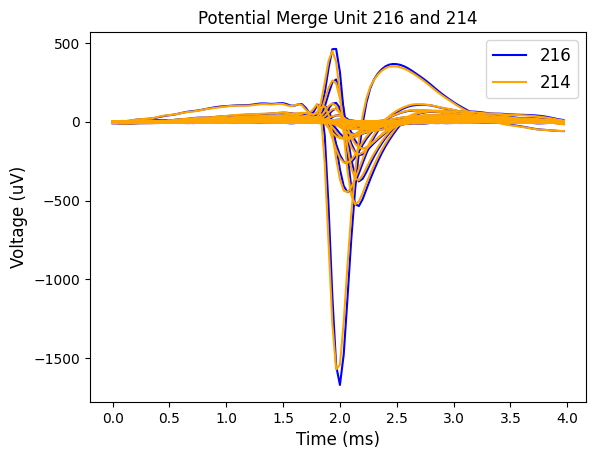

[[0.8934937]]


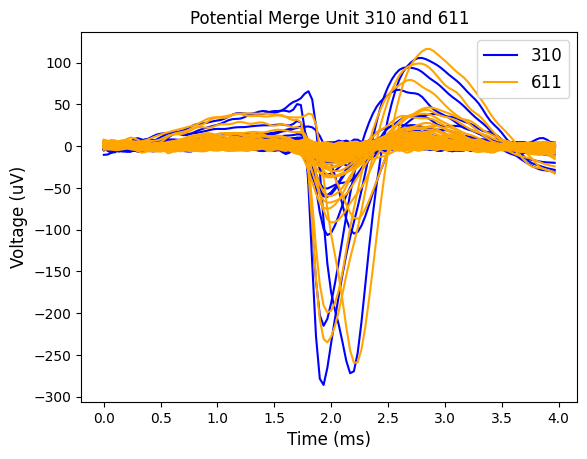

In [17]:
import sklearn 
for pair in curated_merge:
    fig, ax = plt.subplots(1, 1)
    id_1 = pair[0]
    id_2 = pair[1]
    template_1 = we.get_template(unit_id=id_1, mode='average')
    template_2 = we.get_template(unit_id=id_2, mode='average')
    temp_1 = np.array([template_1.flatten()])
    temp_2 = np.array([template_2.flatten()])
    ### get their cosine similirity
    similarity = sklearn.metrics.pairwise.cosine_similarity(temp_1, temp_2)
    print(similarity)
    xx = np.arange(0, 120/fs*1000, 1/fs*1000)
    ax.plot(xx, template_1, color="blue")
    ax.plot(xx, template_2, color='orange')
    ax.plot([],[], "blue", label=str(id_1))
    ax.plot([],[], "orange", label=str(id_2))
    ax.legend(loc='upper right', fontsize=12)  
    ax.set_title("Potential Merge Unit " + str(id_1) + " and " + str(id_2), fontsize=12)
    ax.set_ylabel("Voltage (uV)", fontsize=12)
    ax.set_xlabel("Time (ms)", fontsize=12)
    # plt.savefig("potential_merge_1_0.1_unit "+ str(id_1) + " and " + str(id_2)+".png", dpi=300)
    plt.show()